# [](http://)TI3145TU Final Assignment 
## Health Insurance 

We hope you enjoy this assignment, good luck!

Student names: XXX

Student numbers: XXX

## Part A - Data Exploration and Preprocessing

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.base import clone

### Load data

In [2]:
# These are your training samples along with their labels
data = pd.read_csv('/kaggle/input/health-insurance/health_insurance_train.csv')

X = data.drop('whrswk', axis=1)
y = data['whrswk']

print(data.head())
# You need to extract the features and the regression target. The regression target is 'whrswk'. 

   whrswk  hhi  whi hhi2   education   race hispanic  experience  kidslt6  \
0    40.0   no  yes  yes  13-15years  white       no        17.0      0.0   
1    40.0   no  yes  yes  13-15years  white       no         4.0      1.0   
2     0.0  yes   no  yes     16years  white       no        21.0      0.0   
3    40.0   no   no  yes  13-15years  white       no        22.0      NaN   
4    35.0   no  yes   no     12years  white       no        15.0      0.0   

   kids618   husby        region  
0      1.0  22.000         south  
1      0.0  15.000         south  
2      1.0  99.999         other  
3      NaN  60.000  northcentral  
4      2.0   0.000         south  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [3]:
pd.set_option('display.max_rows', 200)
print(data.head(10))

   whrswk  hhi  whi hhi2   education   race hispanic  experience  kidslt6  \
0    40.0   no  yes  yes  13-15years  white       no        17.0      0.0   
1    40.0   no  yes  yes  13-15years  white       no         4.0      1.0   
2     0.0  yes   no  yes     16years  white       no        21.0      0.0   
3    40.0   no   no  yes  13-15years  white       no        22.0      NaN   
4    35.0   no  yes   no     12years  white       no        15.0      0.0   
5    20.0   no   no   no   9-11years  white       no        25.5      0.0   
6     0.0  yes   no  yes  13-15years  white       no        45.0      0.0   
7    40.0  yes  yes  yes  13-15years  black       no        23.0      0.0   
8     5.0  yes   no  yes  13-15years    NaN       no        20.0      1.0   
9    40.0   no  yes  yes     12years  white       no         9.0      1.0   

   kids618   husby        region  
0      1.0  22.000         south  
1      0.0  15.000         south  
2      1.0  99.999         other  
3      NaN  

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


#### Kijken voor afwijkende data

In [4]:
cols = ['whrswk', 'hhi', 'whi', 'hhi2', 'education', 'race','hispanic',
        'experience', 'kidslt6', 'kids618', 'husby', 'region']

for col in cols:
    zeros = (data[col] == 0).sum()
    others = (data[col] == 'other').sum()
    nans = data[col].isna().sum()
    print(f"{col}: {zeros} zeroes, {nans} NaN's, {others} other")

whrswk: 1477 zeroes, 0 NaN's, 0 other
hhi: 0 zeroes, 0 NaN's, 0 other
whi: 0 zeroes, 0 NaN's, 0 other
hhi2: 0 zeroes, 0 NaN's, 0 other
education: 0 zeroes, 0 NaN's, 0 other
race: 0 zeroes, 500 NaN's, 37 other
hispanic: 0 zeroes, 0 NaN's, 0 other
experience: 6 zeroes, 0 NaN's, 0 other
kidslt6: 3379 zeroes, 500 NaN's, 0 other
kids618: 2641 zeroes, 500 NaN's, 0 other
husby: 950 zeroes, 0 NaN's, 0 other
region: 0 zeroes, 0 NaN's, 1179 other


### Pipeline 1

In [5]:
Num = ['experience', 'kidslt6', 'kids618', 'husby']
Bin_cat = ['hhi', 'whi', 'hhi2', 'hispanic']
Multi_cat = ['race', 'region', 'education']


num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)),
    ('scaler', StandardScaler())
])

prep_1 = ColumnTransformer(
    transformers=[
        ('num_scaled', num_pipe, Num),
        ('bin_cat_ohe', cat_pipe, Bin_cat), 
        ('multi_cat_ohe', cat_pipe, Multi_cat) 
    ],
    remainder = 'drop'
)

In [6]:
X_transformed = prep_1.fit_transform(X)

print(f"1. Initieel aantal rijen en kolommen (X): {X.shape}")
print(f"   Aantal rijen en kolommen na P1:        {X_transformed.shape}")

# .get_feature_names_out() om de getransformeerde kolomnamen te zien
try:
    feature_names = prep_1.get_feature_names_out()
    print(f"\n2. Totaal aantal features na P1: {len(feature_names)}")
    print("   Alle feature namen:")
    print(feature_names)
except Exception as e:
    print(f"\nKon featurenamen niet ophalen: {e}")

X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)
#print("\n3. Eerste 5 rijen van de getransformeerde data (Controle Scaling/OHE):")
#print(X_transformed_df.head())

1. Initieel aantal rijen en kolommen (X): (5000, 11)
   Aantal rijen en kolommen na P1:        (5000, 25)

2. Totaal aantal features na P1: 25
   Alle feature namen:
['num_scaled__experience' 'num_scaled__kidslt6' 'num_scaled__kids618'
 'num_scaled__husby' 'bin_cat_ohe__hhi_no' 'bin_cat_ohe__hhi_yes'
 'bin_cat_ohe__whi_no' 'bin_cat_ohe__whi_yes' 'bin_cat_ohe__hhi2_no'
 'bin_cat_ohe__hhi2_yes' 'bin_cat_ohe__hispanic_no'
 'bin_cat_ohe__hispanic_yes' 'multi_cat_ohe__race_black'
 'multi_cat_ohe__race_other' 'multi_cat_ohe__race_white'
 'multi_cat_ohe__region_northcentral' 'multi_cat_ohe__region_other'
 'multi_cat_ohe__region_south' 'multi_cat_ohe__region_west'
 'multi_cat_ohe__education_12years' 'multi_cat_ohe__education_13-15years'
 'multi_cat_ohe__education_16years' 'multi_cat_ohe__education_9-11years'
 'multi_cat_ohe__education_<9years' 'multi_cat_ohe__education_>16years']


### Pipeline 2

In [7]:
def feature_engineer_p2(X_df):
    X_f = X_df.copy()
    
    # Jongere kinderen hebben meer aandacht nodig dan oudere kinderen 
    X_f['child_burden'] = 2 * X_f['kidslt6'] + X_f['kids618']
    
    # Kwadratische Term voor Husby om non-lineariteit vast te leggen
    X_f['husby_sq'] = X_f['husby'] ** 2
    
    # Man en vrouw hebben beide verzekering door werk vrouw, indicatie vam goede baan vrouw
    X_f['dual_job_insurance'] = ((X_f['whi'] == 'yes') & (X_f['hhi2'] == 'yes')).astype(int)
    
    return X_f

X_f = feature_engineer_p2(X)

In [8]:
# Werkervaring vrouw correlatie met inkomen van man
FE_targets = ['husby', 'experience'] 

# Dit zijn de NIEUWE, numerieke features die geschaald moeten worden
# kidslt6/kids618 en whi/hhi2 vallen af omdat ze nu in resp child_burden en dual_job_insurance zitten
Num_f = ['husby_sq', 'child_burden', 'dual_job_insurance']


num_pipe2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median'))
])

cat_pipe2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False))
])


# Polynomial Feature Extraction (alleen interacties)
pfe_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('poly', PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)),
    ('scaler', StandardScaler())
])

# Pipeline voor Numeriek Passthrough (voor de rest van de numerieke features)
num_pipe_passthrough = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

prep_2 = ColumnTransformer(
    transformers=[
        # PFE op de kritische features (husby, experience)
        ('pfe_feats', pfe_pipe, FE_targets),
        
        # Numeriek Passthrough op de nieuwe FE features
        ('num_pass', num_pipe_passthrough, Num_f), 
        
        ('bin_cat_ohe', cat_pipe2, Bin_cat),
        ('multi_cat_ohe', cat_pipe2, Multi_cat)
    ],
    remainder = 'drop'
)

## Part B - Regression with Default Hyperparameters

### Define models

In [9]:
models_p1 = {
    'KNN Regression': Pipeline(steps=[
        ('preprocessor', prep_1), 
        ('regressor', KNeighborsRegressor(n_neighbors = 5))
    ]),
    'SGD Linear Regression': Pipeline(steps=[
        ('preprocessor', prep_1), 
        ('regressor', SGDRegressor(random_state = 42))
    ]),   
    'Random Forest': Pipeline(steps=[
        ('preprocessor', prep_1), 
        ('regressor', RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)) # n_jobs=-1 voor snellere training
    ]),    
    'Regression Tree': Pipeline(steps=[
        ('preprocessor', prep_1), 
        ('regressor', DecisionTreeRegressor(random_state = 42))
    ])
}


models_p2 = {
    'KNN Regression (P2)': Pipeline(steps=[
        ('preprocessor', prep_2), 
        ('regressor', KNeighborsRegressor(n_neighbors = 5))
    ]),
    'SGD Linear Regression (P2)': Pipeline(steps=[
        ('preprocessor', prep_2), 
        ('regressor', SGDRegressor(random_state = 42))
    ]),
    'Random Forest (P2)': Pipeline(steps=[
        ('preprocessor', prep_2), 
        ('regressor', RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1))
    ]),
    'Regression Tree (P2)': Pipeline(steps=[
        ('preprocessor', prep_2), 
        ('regressor', DecisionTreeRegressor(random_state = 42))
    ])
}

### Base MAE

In [10]:
baseline_guess = y.median()
y_baseline_pred = np.full_like(y, baseline_guess)
mae_baseline = mean_absolute_error(y, y_baseline_pred)

print("--- Baseline Model MAE ---")
print(f"Gok: de mediane uren gewerkt: {baseline_guess:.2f} uur")
print(f"De MAE van deze Baseline Gok: {mae_baseline:.2f} uur")

--- Baseline Model MAE ---
Gok: de mediane uren gewerkt: 35.00 uur
De MAE van deze Baseline Gok: 15.92 uur


In [11]:
all_models = {**models_p1, **models_p2}
results_mae = {}
K_FOLDS = 5

default_results_p2 = {}

for name, model in all_models.items():
    print(f"Start CV voor: {name}...")
    
    # Gebruik X_f voor P2-modellen, X voor P1-modellen.
    data_input = X_f if 'P2' in name else X
    
    scores = cross_val_score(
        model, 
        data_input, y, 
        scoring = 'neg_mean_absolute_error', 
        cv = K_FOLDS, 
        n_jobs = -1
    )
    
    mean_mae = -scores.mean()
    
    # Sla alle resultaten op (voor de samenvatting)
    results_mae[name] = mean_mae 
    
    # Sla ALLEEN de Pipeline 2 resultaten op (voor vergelijking in Stap 11)
    if 'P2' in name:
        default_results_p2[name] = mean_mae 
        
    print(f"{name:<30} - Gem. MAE: {mean_mae:.2f} uur)\n")

print("\n--- MAE prestaties gesorteerd ---")
results_df = pd.Series(results_mae).sort_values()
print(results_df)

print("\n--- Opgeslagen Default P2 MAE's ---")
print(pd.Series(default_results_p2).to_markdown())

Start CV voor: KNN Regression...
KNN Regression                 - Gem. MAE: 12.25 uur)

Start CV voor: SGD Linear Regression...
SGD Linear Regression          - Gem. MAE: 12.30 uur)

Start CV voor: Random Forest...
Random Forest                  - Gem. MAE: 11.80 uur)

Start CV voor: Regression Tree...
Regression Tree                - Gem. MAE: 14.22 uur)

Start CV voor: KNN Regression (P2)...
KNN Regression (P2)            - Gem. MAE: 12.04 uur)

Start CV voor: SGD Linear Regression (P2)...
SGD Linear Regression (P2)     - Gem. MAE: 12.18 uur)

Start CV voor: Random Forest (P2)...
Random Forest (P2)             - Gem. MAE: 11.68 uur)

Start CV voor: Regression Tree (P2)...
Regression Tree (P2)           - Gem. MAE: 13.97 uur)


--- MAE prestaties gesorteerd ---
Random Forest (P2)            11.678096
Random Forest                 11.802474
KNN Regression (P2)           12.035160
SGD Linear Regression (P2)    12.182278
KNN Regression                12.250080
SGD Linear Regression      

Hieruit blijkt duidelijk dat pipeline 2 beter performed dan pipeline 1, daarom gaan we vanaf hier verder met pipeline 2.

## Part C - Tuning with GridSearch

In [12]:
prep = prep_2 
tuned_models = {}

par_grids = {
    'KNN Regression (P2)': {
        'regressor__n_neighbors': [13],
        'regressor__weights': ['uniform']
    },
    'SGD Linear Regression (P2)': {
        'regressor__alpha': [0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001],
        'regressor__penalty': ['l2']
    },
    'Random Forest (P2)': {
        'regressor__n_estimators': [147],
        'regressor__max_depth': [7]
    },
    'Regression Tree (P2)': {
        'regressor__max_depth': [10],
        'regressor__min_samples_leaf': [84]
    }
}

for name, par in par_grids.items():
    
    orig_pipeline = models_p2[name]
    base_pipeline = clone(orig_pipeline)

    grid_search = GridSearchCV(
        estimator = base_pipeline,
        param_grid = par,
        scoring = 'neg_mean_absolute_error',
        cv = 5, n_jobs = -1, verbose = 1
    )
    
    print(f"\nStart GridSearch voor: {name}")
    grid_search.fit(X_f, y)
    
    tuned_models[name] = grid_search
    
    print(f"Beste parameters voor {name}: {grid_search.best_params_}")
    print(f"Beste CV MAE: {-grid_search.best_score_:.4f} uur")

results_df = pd.DataFrame(grid_search.cv_results_)


analysis_cols = [
    'params', 
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
]


analysis_df = results_df[analysis_cols].sort_values(by = 'rank_test_score')
analysis_df['mean_MAE'] = -analysis_df['mean_test_score']


Start GridSearch voor: KNN Regression (P2)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Beste parameters voor KNN Regression (P2): {'regressor__n_neighbors': 13, 'regressor__weights': 'uniform'}
Beste CV MAE: 11.8638 uur

Start GridSearch voor: SGD Linear Regression (P2)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Beste parameters voor SGD Linear Regression (P2): {'regressor__alpha': 1e-95, 'regressor__penalty': 'l2'}
Beste CV MAE: 12.1817 uur

Start GridSearch voor: Random Forest (P2)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Beste parameters voor Random Forest (P2): {'regressor__max_depth': 7, 'regressor__n_estimators': 147}
Beste CV MAE: 11.3868 uur

Start GridSearch voor: Regression Tree (P2)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Beste parameters voor Regression Tree (P2): {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 84}
Beste CV MAE: 11.4378 uur


In [13]:
tuned_results = {}

for name, grid_search_object in tuned_models.items():
    
    mae = -grid_search_object.best_score_ 
    best_index = grid_search_object.best_index_
    std = grid_search_object.cv_results_['std_test_score'][best_index]
    
    tuned_results[name] = mae
    print(f"{name:<30} Tuned MAE: {mae:.4f} uur (+/- {std:.4f} uur)")

KNN Regression (P2)            Tuned MAE: 11.8638 uur (+/- 0.2883 uur)
SGD Linear Regression (P2)     Tuned MAE: 12.1817 uur (+/- 0.2975 uur)
Random Forest (P2)             Tuned MAE: 11.3868 uur (+/- 0.3419 uur)
Regression Tree (P2)           Tuned MAE: 11.4378 uur (+/- 0.3459 uur)


### SGD training curve

Start MAE: 12.1106 uur
Eind MAE na 100 epochs: 11.6373 uur


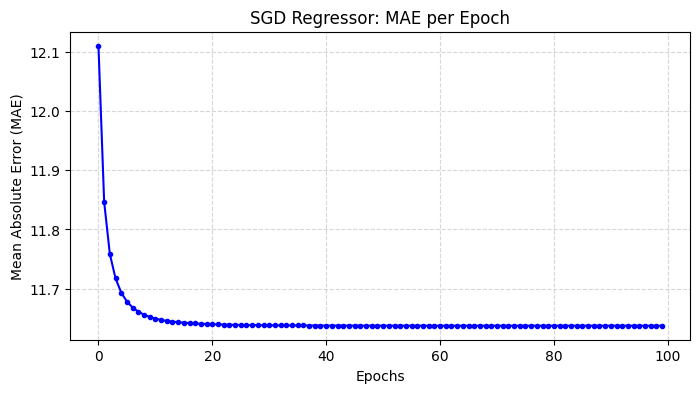

In [14]:
X_train_curve, X_test_curve, y_train_curve, y_test_curve = train_test_split(
    X_f, y, test_size = 0.1, random_state = 42
)

sgd_grid_result = tuned_models['SGD Linear Regression (P2)']
best_sgd_pipeline = sgd_grid_result.best_estimator_

sgd_regressor_params = best_sgd_pipeline.named_steps['regressor'].get_params()

new_sgd_regressor = SGDRegressor(
    **sgd_regressor_params
)

prep_transform = best_sgd_pipeline.named_steps['preprocessor']
X_train_transformed = prep_transform.fit_transform(X_train_curve)
X_test_transformed = prep_transform.transform(X_test_curve)

epochs = 100
mae_history = []

for epoch in range(epochs):
    new_sgd_regressor.partial_fit(X_train_transformed, y_train_curve)
    
    y_pred = new_sgd_regressor.predict(X_test_transformed)
    mae = mean_absolute_error(y_test_curve, y_pred)
    mae_history.append(mae)


print(f"Start MAE: {mae_history[0]:.4f} uur")
print(f"Eind MAE na {epochs} epochs: {mae_history[-1]:.4f} uur")

plt.figure(figsize=(8, 4))
plt.plot(range(len(mae_history)), mae_history, marker='o', markersize=3, linestyle='-', color='blue')
plt.title('SGD Regressor: MAE per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Comparing performance of all models before and after hyperparameter tuning

In [15]:
comparison_data = []
best_overall_mae = float('inf')
best_overall_model = ""

for name, mae_default in default_results_p2.items():
    mae_tuned = tuned_results.get(name, float('nan'))
    
    if not np.isnan(mae_tuned): 
        if mae_tuned < best_overall_mae:
            best_overall_mae = mae_tuned
            best_overall_model = name
            
        improvement = mae_default - mae_tuned
        
        comparison_data.append({
            'Model': name,
            'Default MAE': f"{mae_default:.4f}",
            'Tuned MAE': f"{mae_tuned:.4f}",
            'Improvement': f"{improvement:.4f}"
        })
    else:
        comparison_data.append({
            'Model': name,
            'Default MAE': f"{mae_default:.4f}",
            'Tuned MAE': 'N/A (Tuning Mislukt)',
            'Improvement': 'N/A'
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_markdown(index = False))

print(f"\nBest model after hyperparameter tuning is: {best_overall_model} with a MAE of {best_overall_mae:.4f}.")

| Model                      |   Default MAE |   Tuned MAE |   Improvement |
|:---------------------------|--------------:|------------:|--------------:|
| KNN Regression (P2)        |       12.0352 |     11.8638 |        0.1713 |
| SGD Linear Regression (P2) |       12.1823 |     12.1817 |        0.0005 |
| Random Forest (P2)         |       11.6781 |     11.3868 |        0.2913 |
| Regression Tree (P2)       |       13.9737 |     11.4378 |        2.536  |

Best model after hyperparameter tuning is: Random Forest (P2) with a MAE of 11.3868.


# Autograder 

In the autograder you will need to provide two things: 1) estimate of the MAE of your model on unseen data, 2) the predictions on the autograder data. For the autograder data we only provide the features and not the regression targets. Thus, you cannot compute the MAE on this data yourself - you need to estimate that with the data provided above. 

In [16]:
data_autograder = pd.read_csv('/kaggle/input/autograder/health_insurance_autograde.csv')
data_autograder.head()


,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,region
0,no,yes,no,16years,white,no,25.0,0.0,0.0,0.0,west
1,no,no,no,12years,white,no,41.0,0.0,0.0,0.0,south
2,yes,yes,yes,>16years,white,no,21.0,0.0,2.0,34.3,other
3,no,yes,yes,9-11years,NaN,no,46.5,0.0,0.0,0.0,other
4,no,no,no,13-15years,white,no,9.0,0.0,0.0,25.0,northcentral


In [17]:
BEST_MODEL_NAME = best_overall_model
BEST_MAE_ESTIMATE = best_overall_mae

best_model_pipeline = tuned_models[BEST_MODEL_NAME]

print("\n" + "="*50)
print(f"Final Model: {BEST_MODEL_NAME} wordt getraind op alle data.")
print("="*50)

# Train de pipeline op de VOLLEDIGE trainingsdataset
final_best_model = best_model_pipeline.fit(X_f, y)
print("Training voltooid. Start voorspelling op autograder data.")

data_autograder_f = feature_engineer_p2(data_autograder)

predictions_autograder_data = final_best_model.predict(data_autograder_f)
predictions_autograder_data = np.maximum(0, predictions_autograder_data)
print(predictions_autograder_data)


Final Model: Random Forest (P2) wordt getraind op alle data.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training voltooid. Start voorspelling op autograder data.
[40.14296143  3.86616581 41.90130667 ... 15.48590461 23.61036075
 21.5246007 ]


In [18]:
# TODO Replace this with your own estimate of the MAE of your best model
estimate_MAE_on_new_data = np.array([BEST_MAE_ESTIMATE])

# TODO Replace this with the predictions of your best model
# via e.g. prediction = model.predict(data_autograder)
predictions_autograder_data = predictions_autograder_data.round(4)

# Upload this file to the Vocareum autograder:
result = np.append(estimate_MAE_on_new_data, predictions_autograder_data)
pd.DataFrame(result).to_csv("autograder_submission.txt", index=False, header=False)